In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, k_means, dbscan
from sklearn.mixture import GaussianMixture
import fastcluster
from scipy.cluster.hierarchy import fcluster
import hdbscan 
from sklearn_som.som import SOM
import genieclust

In [2]:
X_small_path = 'data/unsupervised/small/graph.data.gz'
y_small_path = 'data/unsupervised/small/graph.labels0.gz'
X_large_path = 'data/unsupervised/large/h2mg_128_60.data.gz'
y_large_path = 'data/unsupervised/large/h2mg_128_60.labels0.gz'


def load_data(X_path, y_path):
    X = np.loadtxt(X_path)
    y = np.loadtxt(y_path) - 1
    clusters, cluster_counts = np.unique(y, return_counts=True)
    n_clusters = len(clusters)
    return X, y, clusters, cluster_counts, n_clusters


In [3]:
X_small, y_small, clusters_small, cluster_counts_small, n_clusters_small = load_data(X_small_path, y_small_path)

print(n_clusters_small)
print(clusters_small)
print(cluster_counts_small)

10
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]
[250 250 250 250 250 250 250 250 250 250]


In [293]:
def gmm_(X: np.ndarray, n_clusters: int, **kwargs) -> np.ndarray:
    return GaussianMixture(n_components=n_clusters, **kwargs).fit_predict(X)


def hdbscan_(X: np.ndarray, cluster_selection_epsilon=0., **kwargs) -> np.ndarray:
    return hdbscan.hdbscan(X, cluster_selection_epsilon=cluster_selection_epsilon, **kwargs)[0]


def k_means_(X: np.ndarray, n_clusters: int, **kwargs) -> np.ndarray:
    return k_means(X, n_clusters, **kwargs)[1]


def dbscan_(X: np.ndarray, eps=0.5, **kwargs) -> np.ndarray:
    return dbscan(X, eps, **kwargs)[1]


def som_(X: np.ndarray, m=3, n=3, **kwargs) -> np.ndarray:
    return SOM(m=m, n=n, dim=X.shape[1], **kwargs).fit_predict(X)


def hac_single_(X, n_clusters):
    return fcluster(fastcluster.single(X), n_clusters, criterion='maxclust')


def hac_average_(X, n_clusters):
    return fcluster(fastcluster.average(X), n_clusters, criterion='maxclust')


def hac_complete_(X, n_clusters):
    return fcluster(fastcluster.complete(X), n_clusters, criterion='maxclust')


def hac_ward_(X, n_clusters):
    return fcluster(fastcluster.ward(X), n_clusters, criterion='maxclust')

In [4]:
scoring = {
    'ARI': metrics.adjusted_rand_score,
    'AMI': metrics.adjusted_mutual_info_score,
    'V-measure': metrics.v_measure_score
}

For DBSCAN and HDBSCAN we need 10 + 1 = 11 classes. We try different hyperparameter values, so that we get this number. We find that `eps=1.81, cluster_selection_epsilon=1.935` give us 11 classes.

In [299]:
# for eps in np.linspace(0, 3, 300)[1:]:
#     print(eps, len(np.unique(dbscan_(X_small, eps=eps))))
#
# for cse in np.linspace(0, 3, 300):    
#     print(cse, len(np.unique(hdbscan_(X_small, cluster_selection_epsilon=float(cse)))))
#
# # eps=1.81, cluster_selection_epsilon=1.935

In [300]:
def cluster(X, n_clusters, m, n, eps, cluster_selection_epsilon):
    return {
        'K-Means': k_means_(X, n_clusters),
        'HAC_Single': hac_single_(X, n_clusters),
        'HAC_Average': hac_average_(X, n_clusters),
        'HAC_Complete': hac_complete_(X, n_clusters),
        'HAC_Ward': hac_ward_(X, n_clusters),
        'GMM': gmm_(X, n_clusters),
        'DBSCAN': dbscan_(X, eps),
        'HDBSCAN': hdbscan_(X, cluster_selection_epsilon),
        'SOM': som_(X, m=m, n=n)
    }

In [301]:
res_small = cluster(X_small, n_clusters_small, m=2, n=5, eps=1.81, cluster_selection_epsilon=1.935)
# eps=1.84, cluster_selection_epsilon=1.96

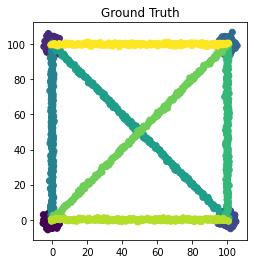

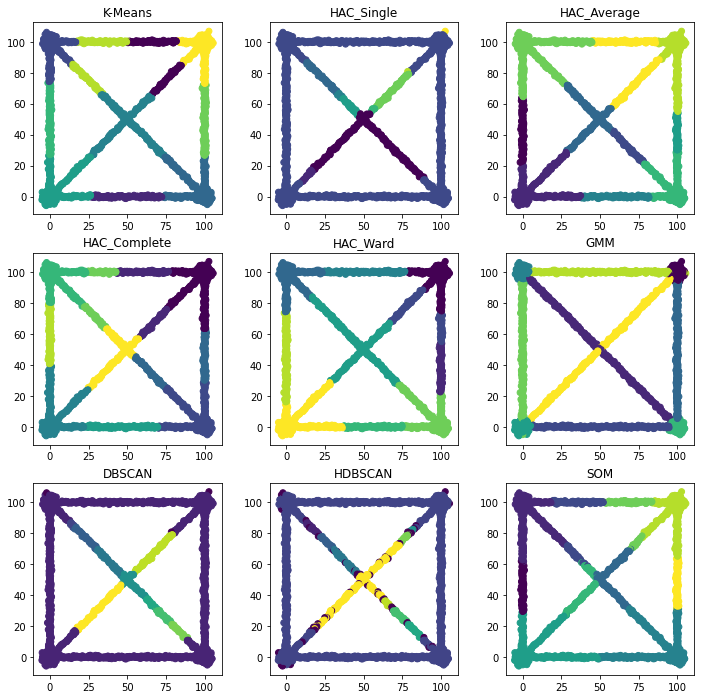

In [303]:
def plot_clusters(X, z, title=None, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.scatter(X[:,0], X[:,1], c=z)
    ax.set_aspect('equal', 'box')
    ax.set_title(title)


def plot_dbscan():
    pass


def plot_clusters_grid(X, zs: dict):
    # add the original cluster as well
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
    for (name, z), ax in zip(zs.items(), axs.flat):
        # if name in ('DBSCAN', 'HDBSCAN'):
        #     plot_dbscan()
        # else:
        #     plot_clusters(X, z, title=name, ax=ax)
        plot_clusters(X, z, title=name, ax=ax)

plot_clusters(X_small, y_small, title='Ground Truth')
plot_clusters_grid(X_small, res_small)
# plt.show()